# MNIST: convolutional neural networks

We define and train a convolutional neural network (CNN) model to recognize handwritten digits.  Although CNNs can be used in many contexts, they are probably most often used in the context of image processing.

## Required imports

In [2]:
from tensorflow import keras
from keras import backend as K
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

2024-03-20 09:41:54.169958: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 09:41:54.317733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 09:41:54.317777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 09:41:54.324785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 09:41:54.351696: I tensorflow/core/platform/cpu_feature_guar

## Data preparation

Depending on the backend keras uses, the input format slightly differs. Either the number of color channels is the first, or the last dimension.  Our input data is grayscale, so there is only a single color channel

In [3]:
img_channels, img_rows, img_cols = 1, 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (img_channels, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, img_channels)

Load the data again.

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Data preprocessing

First, reshape the input data to take into account the color channels of the images.

In [5]:
input_pipeline = FunctionTransformer(lambda x: x.reshape((x.shape[0], ) + shape_ord).astype(np.float32)/255.0,
                                     validate=False)

In [6]:
x_train = input_pipeline.fit_transform(x_train)
x_test = input_pipeline.transform(x_test)

Most learning algorithms work better when the input data is normalized to the interval $[0, 1]$.

The output can be transformed using the pipeline defined for the multilayer network and can be imported from the `mnist_utils` module.

In [7]:
output_reshaper = FunctionTransformer(lambda x: x.reshape(-1, 1),                                                                                                                                        
                                      validate=False)                                                                                                                                                    
output_encoder = OneHotEncoder(categories='auto')
output_type_changer = FunctionTransformer(lambda x: x.astype(np.float32),
                                          validate=False)
output_pipeline = Pipeline([
    ('reshaper', output_reshaper),
    ('binarizer', output_encoder),
    ('type_changer', output_type_changer),
])

In [8]:
y_train = output_pipeline.fit_transform(y_train)
y_test = output_pipeline.transform(y_test)

### Validation data

In order to make this reproducible, we have to seed the random number generator.

In [9]:
np.random.seed(1234)

During the training, we will require a validation set, so we split the training data into two sets, one for actual training, the other for validation.  Note, we don't touch the test data set at all during the training process.  The default is using 75 % of the data for training, 25 % for validation. This function will also shuffle the data set prior to splitting (hence seeding the random number generator).

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

In [11]:
x_train.shape, x_val.shape, x_train.dtype, y_train.shape, y_val.shape, y_train.dtype

((45000, 28, 28, 1),
 (15000, 28, 28, 1),
 dtype('float32'),
 (45000, 10),
 (15000, 10),
 dtype('float32'))

### Verification

Since we've done quite some transformations, let's verify whether we didn't mess up.

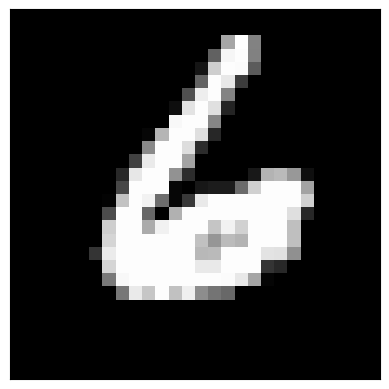

In [12]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0, :, :, 0], cmap='gray');

In [13]:
print(y_train[0])

  (0, 6)	1.0


## Simple CNN

We start with a very straightforward network with a single convolutional layer.

### Required imports

In [14]:
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten
from keras.optimizers import SGD
import tensorflow as tf

Seed TensorFlow's random number generator.

In [17]:
tf.random.set_seed(40580)

### Model definition

The network has 32 filters, each 3 $\times$ 3 pixels in its convolutional layer, and a ReLU activation function. For the second, dense layer, the output of the convolutional layer is first flattened. The dense layer's activation function is SoftMax to determine the category for the image.

In [18]:
nr_filters = 32
nr_classes = 10
conv_x_size, conv_y_size = 3, 3
cnn_model = Sequential()
cnn_model.add(Conv2D(nr_filters, (conv_x_size, conv_y_size), padding='valid',
                     input_shape=shape_ord))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(nr_classes))
cnn_model.add(Activation('softmax'))

2024-03-20 09:44:30.874590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 09:44:31.124149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 09:44:31.124213: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 09:44:31.127355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 09:44:31.127395: I external/local_xla/xla/stream_executor

In [19]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 10)                216330    
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 216650 (846.29 KB)
Trainable params: 216650 (846.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
cnn_hist = cnn_model.compile(loss='categorical_crossentropy',
                             optimizer=SGD(lr=0.1, decay=1.0e-6, 
                                           momentum=0.9, nesterov=True),
                             metrics=['accuracy'])

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.SGD.

### Training

In [ ]:
cnn_hist = cnn_model.fit(x_train, y_train, batch_size=32, epochs=10,
                         verbose=1, validation_data=(x_val, y_val))

In [ ]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')

In [ ]:
plot_history(cnn_hist)

In [ ]:
cnn_model.evaluate(x_test, y_test)

Although the test accuracy is quite acceptable, the training accuracy is a lot higher, so most likely there is some overfitting.

In [ ]:
cnn_model.save('mnist_cnn.h5')

## More layers & dropout

This model has an additional hidden layer to improve accuracy.

In [ ]:
nr_filters = 32
nr_classes = 10
conv_x_size, conv_y_size = 3, 3
cnn_do_model = Sequential()
cnn_do_model.add(Conv2D(nr_filters, (conv_x_size, conv_y_size), padding='valid',
                     input_shape=shape_ord))
cnn_do_model.add(Activation('relu'))
cnn_do_model.add(Flatten())
cnn_do_model.add(Dense(128))
cnn_do_model.add(Activation('relu'))
cnn_do_model.add(Dropout(0.1))
cnn_do_model.add(Dense(nr_classes))
cnn_do_model.add(Activation('softmax'))

In [ ]:
cnn_do_model.summary()

In [ ]:
cnn_do_model.compile(loss='categorical_crossentropy',
                     optimizer=SGD(),
                     metrics=['accuracy'])

In [ ]:
cnn_do_hist = cnn_do_model.fit(x_train, y_train, batch_size=32, epochs=10,
                               verbose=1, validation_data=(x_val, y_val))

In [ ]:
plot_history(cnn_do_hist)

In [ ]:
cnn_do_model.evaluate(x_test, y_test)

Now the accuracies for training, validation and test data are more in line.

In [ ]:
cnn_do_model.save('mnist_cnn_do.h5')